# MNIST handwritten digits classification with MLPs

In this notebook, we'll train a multi-layer perceptron model to classify MNIST digits using **PyTorch**. 

First, the needed imports. 

In [2]:
%load_ext autoreload
%autoreload 2

In [43]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import copy
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.13.0+cu117  Device: cuda


## Data

Next we'll load the MNIST data.  First time we may have to download the data, which can take a while.

Note that we are here using the MNIST test data for *validation*, instead of for testing the final model.

In [44]:
batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

The train and test data are provided via data loaders that provide iterators over the datasets. The first element of training data (`X_train`) is a 4th-order tensor of size (`batch_size`, 1, 28, 28), i.e. it consists of a batch of images of size 1x28x28 pixels. `y_train` is a vector containing the correct classes ("0", "1", ..., "9") for each training digit.

In [45]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Here are the first 10 training digits:

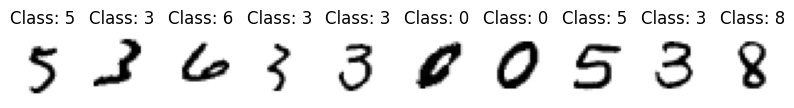

In [46]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

## MLP network definition

Let's define the network as a Python class.  We have to write the `__init__()` and `forward()` methods, and PyTorch will automatically generate a `backward()` method for computing the gradients for the backward pass.

Finally, we define an optimizer to update the model parameters based on the computed gradients.  We select *stochastic gradient descent (with momentum)* as the optimization algorithm, and set *learning rate* to 0.01.  Note that there are [several different options](http://pytorch.org/docs/optim.html#algorithms) for the optimizer in PyTorch that we could use instead of *SGD*.

In [47]:
class Net(nn.Module):
    def __init__(self, hidden_size=50, weights=None):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_size, bias=False)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_size, hidden_size, bias=False)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(hidden_size, 10, bias=False)

        if weights is not None:
            assert len(weights) == 3
            with torch.no_grad():
                self.fc1.weight = nn.Parameter(weights[0])
                self.fc2.weight = nn.Parameter(weights[1])
                self.fc3.weight = nn.Parameter(weights[2])

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)

    def __add__(self, other):
        diff_model = copy.deepcopy(self)
        with torch.no_grad():
            for \
                (first_model_param_name, first_model_param), \
                (second_model_param_name, second_model_param), \
                (diff_model_param_name, diff_model_param) in zip(
                self.named_parameters(), 
                other.named_parameters(),
                diff_model.named_parameters()
            ):
                assert first_model_param_name == second_model_param_name == diff_model_param_name
                assert first_model_param.shape == second_model_param.shape == diff_model_param.shape
                diff_model_param.copy_(
                    first_model_param +
                    second_model_param
                )
        return diff_model

    def __sub__(self, other):
        diff_model = copy.deepcopy(self)
        with torch.no_grad():
            for \
                (first_model_param_name, first_model_param), \
                (second_model_param_name, second_model_param), \
                (diff_model_param_name, diff_model_param) in zip(
                self.named_parameters(), 
                other.named_parameters(),
                diff_model.named_parameters()
            ):
                assert first_model_param_name == second_model_param_name == diff_model_param_name
                assert first_model_param.shape == second_model_param.shape == diff_model_param.shape
                diff_model_param.copy_(
                    first_model_param -
                    second_model_param
                )
        return diff_model

    def __mul__(self, scalar):
        result_model = copy.deepcopy(self)
        with torch.no_grad():
            for \
                (_, model_param), \
                (_, result_model_param) in zip(
                self.named_parameters(), 
                result_model.named_parameters()
            ):
                result_model_param.copy_(
                    model_param * scalar
                )
        return result_model

## Learning

Let's now define functions to `train()` and `validate()` the model. 

In [48]:
def train(model, optimizer, criterion, epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [49]:
def validate(model, criterion, loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))


Now we are ready to train our model using the `train()` function.  An *epoch* means one pass through the whole training data. After each epoch, we evaluate the model using `validate()`. 

In [50]:
# model = Net().to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
# criterion = nn.CrossEntropyLoss()

# print(model)

In [51]:
# %%time
# epochs = 10

# lossv, accv = [], []
# for epoch in range(1, epochs + 1):
#     train(epoch)
#     validate(lossv, accv)

Let's now visualize how the training progressed. 

* *Loss* is a function of the difference of the network output and the target values.  We are minimizing the loss function during training so it should decrease over time.
* *Accuracy* is the classification accuracy for the test data.

In [52]:
# plt.figure(figsize=(5,3))
# plt.plot(np.arange(1,epochs+1), lossv)
# plt.title('validation loss')

# plt.figure(figsize=(5,3))
# plt.plot(np.arange(1,epochs+1), accv)
# plt.title('validation accuracy');

## Model tuning

Modify the MLP model.  Try to improve the classification accuracy, or experiment with the effects of different parameters.  If you are interested in the state-of-the-art performance on permutation invariant MNIST, see e.g. this [recent paper](https://arxiv.org/abs/1507.02672) by Aalto University / The Curious AI Company researchers.

You can also consult the PyTorch documentation at http://pytorch.org/.

# Alignment experiments

### Train multiple MLPs with different hidden sizes

In [53]:
N_EPOCHS_SHORT = 1
N_EPOCHS = 10
N_MODELS = 2
models = defaultdict(dict)
for i in range(N_MODELS):
    model = Net(hidden_size=30 * (i + 1)).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    criterion = nn.CrossEntropyLoss()

    models['untrained'][i] = copy.deepcopy(model).to('cpu')

    lossv, accv = [], []
    for epoch in range(1, N_EPOCHS + 1):
        train(model, optimizer, criterion, epoch)
        validate(model, criterion, lossv, accv)
    
    models['trained'][i] = model.to('cpu')

    model = copy.deepcopy(models['untrained'][i]).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    criterion = nn.CrossEntropyLoss()

    lossv, accv = [], []
    for epoch in range(1, N_EPOCHS_SHORT + 1):
        train(model, optimizer, criterion, epoch)
        validate(model, criterion, lossv, accv)
    
    models['trained_short'][i] = model.to('cpu')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305997
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.249061
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.664477
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.171325
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.718018
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.618686
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.072273
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.515163
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.633971
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.565271

Validation set: Average loss: 0.4023, Accuracy: 8905/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.532290
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.652178
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.917626
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.464457
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.657096
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.624577
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.371708
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.202223
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.64

In [54]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [55]:
for i in range(N_MODELS):
    print(get_n_params(models['untrained'][i]))
    validate(models['untrained'][i].to(device), criterion, [], [])
    validate(models['trained'][i].to(device), criterion, [], [])

24720

Validation set: Average loss: 2.3045, Accuracy: 871/10000 (9%)


Validation set: Average loss: 0.1503, Accuracy: 9542/10000 (95%)

51240

Validation set: Average loss: 2.3043, Accuracy: 753/10000 (8%)


Validation set: Average loss: 0.1128, Accuracy: 9666/10000 (97%)



### Use OT fusion to map smaller model to bigger

In [56]:
from wasserstein_ensemble import get_wassersteinized_layers_modularized
from parameters import get_parser

In [57]:
parser = get_parser()
args = parser.parse_args('--gpu-id 1 --model-name mlpnet --n-epochs 10 --save-result-file sample.csv \
--sweep-name exp_sample --exact --correction --ground-metric euclidean --weight-stats \
--activation-histograms --activation-mode raw --geom-ensemble-type acts --sweep-id 21 \
--act-num-samples 200 --ground-metric-normalize none --activation-seed 21 \
--prelu-acts --recheck-acc --load-models ./mnist_models --ckpt-type final \
--past-correction --not-squared --dist-normalize --print-distances --to-download'.split())

In [58]:
args.gpu_id = 0
args.proper_marginals = True
args.skip_last_layer = False

Basic check with two trained models

In [59]:
_, aligned, _ = get_wassersteinized_layers_modularized(args, [models['trained'][0], models['trained'][1]])

Previous layer shape is  None
Layer ('fc1.weight', 'fc1.weight') shape is torch.Size([30, 784]) and torch.Size([60, 784])
Processing the coordinates to form ground_metric
dont leave off the squaring of the ground metric
returns a uniform measure of cardinality:  30
returns a uniform measure of cardinality:  60
mu shape is (30,)
nu shape is (60,)
cpuM shape is (30, 60)
the transport map is  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0167, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0167],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0167, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')
shape of inverse marginals beta is  torch.Size([60])
inverse marginals beta is  tensor([0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.0167,
        0.0167, 0.0167, 0

In [60]:
aligned[0].shape, aligned[1].shape, aligned[2].shape

(torch.Size([60, 784]), torch.Size([60, 60]), torch.Size([10, 60]))

In [61]:
model = Net(30)
validate(model.to(device), criterion, [], [])
with torch.no_grad():
    model.fc1.weight = nn.Parameter(aligned[0])
    model.fc2.weight = nn.Parameter(aligned[1])
    model.fc3.weight = nn.Parameter(aligned[2])
validate(model.to(device), criterion, [], [])


Validation set: Average loss: 2.3010, Accuracy: 1106/10000 (11%)


Validation set: Average loss: 0.3554, Accuracy: 9542/10000 (95%)



In [62]:
models['trained'][0].fc1.weight

Parameter containing:
tensor([[ 0.0197,  0.0026, -0.0086,  ...,  0.0139,  0.0211, -0.0080],
        [ 0.0229,  0.0041, -0.0075,  ...,  0.0052, -0.0145, -0.0315],
        [-0.0270, -0.0153, -0.0229,  ..., -0.0144,  0.0126,  0.0059],
        ...,
        [-0.0269,  0.0328,  0.0289,  ..., -0.0211,  0.0264, -0.0116],
        [-0.0291, -0.0253,  0.0140,  ...,  0.0342,  0.0201, -0.0349],
        [ 0.0026,  0.0251, -0.0321,  ..., -0.0235,  0.0355,  0.0336]],
       device='cuda:0', requires_grad=True)

In [63]:
models['trained'][1].fc1.weight

Parameter containing:
tensor([[ 0.0080,  0.0211,  0.0319,  ..., -0.0145,  0.0116, -0.0025],
        [ 0.0028,  0.0111, -0.0079,  ...,  0.0042, -0.0204, -0.0327],
        [-0.0170,  0.0091, -0.0306,  ...,  0.0275,  0.0010,  0.0322],
        ...,
        [-0.0356,  0.0190, -0.0090,  ..., -0.0244,  0.0352, -0.0265],
        [ 0.0356, -0.0008,  0.0066,  ...,  0.0232, -0.0141, -0.0236],
        [ 0.0015, -0.0011,  0.0300,  ..., -0.0357,  0.0242, -0.0193]],
       device='cuda:0', requires_grad=True)

In [64]:
model.fc1.weight

Parameter containing:
tensor([[ 0.0306, -0.0144,  0.0178,  ...,  0.0047,  0.0271, -0.0340],
        [-0.0040,  0.0267, -0.0113,  ...,  0.0215, -0.0124,  0.0213],
        [ 0.0044, -0.0259,  0.0275,  ...,  0.0112, -0.0187,  0.0122],
        ...,
        [ 0.0197,  0.0026, -0.0086,  ...,  0.0139,  0.0211, -0.0080],
        [-0.0270, -0.0153, -0.0229,  ..., -0.0144,  0.0126,  0.0059],
        [ 0.0229,  0.0041, -0.0075,  ...,  0.0052, -0.0145, -0.0315]],
       device='cuda:0', requires_grad=True)

Check that Ts are or to be reused

In [65]:
_, aligned1, T_vars = get_wassersteinized_layers_modularized(args, [models['trained'][0], models['trained'][1]])
_, aligned2, _ = get_wassersteinized_layers_modularized(args, [models['trained'][0], models['trained'][1]], T_vars_pre_computed=T_vars)
with torch.no_grad():
    for a1, a2 in zip(aligned1, aligned2):
        assert np.allclose(a1.cpu().numpy(), a2.cpu().numpy())

Previous layer shape is  None
Layer ('fc1.weight', 'fc1.weight') shape is torch.Size([30, 784]) and torch.Size([60, 784])
Processing the coordinates to form ground_metric
dont leave off the squaring of the ground metric
returns a uniform measure of cardinality:  30
returns a uniform measure of cardinality:  60
mu shape is (30,)
nu shape is (60,)
cpuM shape is (30, 60)
the transport map is  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0167, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0167],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0167, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')
shape of inverse marginals beta is  torch.Size([60])
inverse marginals beta is  tensor([0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.0167,
        0.0167, 0.0167, 0

TypeError: trace(): argument 'input' (position 1) must be Tensor, not tuple

In [68]:
models['untrained'][0].fc1.weight.get_device(), \
models['trained'][0].fc1.weight.get_device(), \
models['trained_short'][0].fc1.weight.get_device()

(0, 0, -1)

In [69]:
for i in range(1, N_MODELS):
    _, _, T_vars = get_wassersteinized_layers_modularized(args, [models['untrained'][i - 1], models['untrained'][i]])
    _, aligned_untrained, _ = get_wassersteinized_layers_modularized(
        args, 
        [models['trained'][i - 1], models['untrained'][i]], 
        T_vars_pre_computed=[T_var[1] for T_var in T_vars]
    )
    model = Net(weights=aligned_untrained)
    models['aligned_untrained'][i] = model.to('cpu')
    print(f'aligned_untrained[0].shape == {aligned_untrained[0].shape}')
    print(f"models['aligned_untrained'][i].fc1.weight.shape == {models['aligned_untrained'][i].fc1.weight.shape}")

    models['trained_short'][i].to(device)
    _, aligned, T_vars = get_wassersteinized_layers_modularized(args, [models['trained'][i - 1], models['trained_short'][i]])
    model = Net(weights=aligned)
    models['aligned'][i] = model.to('cpu')
    print(f'aligned[0].shape == {aligned[0].shape}')
    print(f"models['trained'][i].fc1.weight.shape == {models['trained'][i].fc1.weight.shape}")

    _, aligned_diff, _ = get_wassersteinized_layers_modularized(
        args, 
        [
            models['trained'][i - 1] - models['untrained'][i - 1], 
            models['untrained'][i]
        ], 
        T_vars_pre_computed=[T_var[1] for T_var in T_vars]
    )
    model = Net(weights=aligned_diff) + models['untrained'][i]
    models['aligned_diff'][i] = model.to('cpu')
    print(f'aligned_diff[0].shape == {aligned_diff[0].shape}')
    print(f"models['trained'][i].fc1.weight.shape == {models['trained'][i].fc1.weight.shape}")

Previous layer shape is  None
Layer ('fc1.weight', 'fc1.weight') shape is torch.Size([30, 784]) and torch.Size([60, 784])
Processing the coordinates to form ground_metric
dont leave off the squaring of the ground metric
returns a uniform measure of cardinality:  30
returns a uniform measure of cardinality:  60
mu shape is (30,)
nu shape is (60,)
cpuM shape is (30, 60)
the transport map is  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0167, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')
shape of inverse marginals beta is  torch.Size([60])
inverse marginals beta is  tensor([0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.0167,
        0.0167, 0.0167, 0

In [70]:
for i in range(N_MODELS):
    print(f'=============== MODEL {i} ==================')
    print('Untrained:')
    validate(models['untrained'][i].to(device), criterion, [], [])
    print('Trained:')
    validate(models['trained'][i].to(device), criterion, [], [])
    print('Trained short:')
    validate(models['trained_short'][i].to(device), criterion, [], [])
    print('Aligned untrained:')
    if i in models['aligned_untrained']:
        validate(models['aligned_untrained'][i].to(device), criterion, [], [])
    else:
        print('------------')
    print('Aligned:')
    if i in models['aligned']:
        validate(models['aligned'][i].to(device), criterion, [], [])
    else:
        print('------------')
    print('Aligned diff:')
    if i in models['aligned_diff']:
        validate(models['aligned_diff'][i].to(device), criterion, [], [])
    else:
        print('------------')

=============== MODEL 0 ==================
Untrained:

Validation set: Average loss: 2.3045, Accuracy: 871/10000 (9%)

Trained:

Validation set: Average loss: 0.1503, Accuracy: 9542/10000 (95%)

Trained short:

Validation set: Average loss: 0.4047, Accuracy: 8906/10000 (89%)

Aligned untrained:
------------
Aligned:
------------
Aligned diff:
------------
=============== MODEL 1 ==================
Untrained:

Validation set: Average loss: 2.3043, Accuracy: 753/10000 (8%)

Trained:

Validation set: Average loss: 0.1128, Accuracy: 9666/10000 (97%)

Trained short:

Validation set: Average loss: 0.3470, Accuracy: 9000/10000 (90%)

Aligned untrained:

Validation set: Average loss: 35.5676, Accuracy: 73/10000 (1%)

Aligned:

Validation set: Average loss: 0.3554, Accuracy: 9542/10000 (95%)

Aligned diff:

Validation set: Average loss: 0.3543, Accuracy: 9444/10000 (94%)



In [71]:
_, aligned, T_vars = get_wassersteinized_layers_modularized(args, [models['trained'][0], models['trained_short'][4]])
model = Net(weights=aligned)
print(f'aligned[0].shape == {aligned[0].shape}')
print(f"models['trained'][i].fc1.weight.shape == {models['trained'][i].fc1.weight.shape}")
validate(model.to(device), criterion, [], [])

KeyError: 4

In [72]:
models['aligned']

{1: Net(
   (fc1): Linear(in_features=784, out_features=50, bias=False)
   (fc1_drop): Dropout(p=0.2, inplace=False)
   (fc2): Linear(in_features=50, out_features=50, bias=False)
   (fc2_drop): Dropout(p=0.2, inplace=False)
   (fc3): Linear(in_features=50, out_features=10, bias=False)
 )}

In [73]:
models['aligned']

{1: Net(
   (fc1): Linear(in_features=784, out_features=50, bias=False)
   (fc1_drop): Dropout(p=0.2, inplace=False)
   (fc2): Linear(in_features=50, out_features=50, bias=False)
   (fc2_drop): Dropout(p=0.2, inplace=False)
   (fc3): Linear(in_features=50, out_features=10, bias=False)
 )}

In [74]:
scaling = dict()
for idx, ((layer0_name, fc_layer0_weight), (layer1_name, fc_layer1_weight)) in \
        enumerate(zip(models['trained'][0].named_parameters(), models['aligned'][1].named_parameters())):
    with torch.no_grad():
        scaling[layer0_name] = ((fc_layer0_weight.abs() ** 2).sum() ** 0.5 / (fc_layer1_weight.abs() ** 2).sum() ** 0.5).cpu().numpy()
        print(scaling[layer0_name], fc_layer0_weight.shape, fc_layer1_weight.shape)
        print(
            70 / 30,
            fc_layer0_weight.abs().mean() /
            fc_layer1_weight.abs().mean(),
            fc_layer0_weight.abs().mean(), 
            fc_layer1_weight.abs().mean(),
            fc_layer0_weight.mean(), 
            fc_layer1_weight.mean(),
        )
        print()

0.7071111 torch.Size([30, 784]) torch.Size([60, 784])
2.3333333333333335 tensor(1.0000, device='cuda:0') tensor(0.0389, device='cuda:0') tensor(0.0389, device='cuda:0') tensor(-0.0041, device='cuda:0') tensor(-0.0041, device='cuda:0')

0.5000061 torch.Size([30, 30]) torch.Size([60, 60])
2.3333333333333335 tensor(1.0000, device='cuda:0') tensor(0.2008, device='cuda:0') tensor(0.2008, device='cuda:0') tensor(0.0183, device='cuda:0') tensor(0.0183, device='cuda:0')

0.7071117 torch.Size([10, 30]) torch.Size([10, 60])
2.3333333333333335 tensor(1.0000, device='cuda:0') tensor(0.3651, device='cuda:0') tensor(0.3651, device='cuda:0') tensor(-0.0095, device='cuda:0') tensor(-0.0095, device='cuda:0')



In [36]:
model = Net(hidden_size=1000).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

lossv, accv = [], []
for epoch in range(1, N_EPOCHS_SHORT + 1):
    train(model, optimizer, criterion, epoch)
    validate(model, criterion, lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.294997
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.847028
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.607638
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.529232
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.483924
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.266716
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.481619
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.339755
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.449372
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.370931

Validation set: Average loss: 0.3060, Accuracy: 9156/10000 (92%)

Previous layer shape is  None
Processing the coordinates to form ground_metric
dont leave off the squaring of the ground metric
returns a uniform measure of cardinality:  30
returns a uniform measure of cardinality:  1000
the transport map is  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
   

In [37]:
average, aligned, T_vars = get_wassersteinized_layers_modularized(args, [models['trained'][0], model])
model = Net(weights=aligned)
print(f'aligned[0].shape == {aligned[0].shape}')
print(f"models['trained'][i].fc1.weight.shape == {models['trained'][i].fc1.weight.shape}")
validate(model.to(device), criterion, [], [])
model = Net(weights=average)
print(f'average[0].shape == {average[0].shape}')
validate(model.to(device), criterion, [], [])

Previous layer shape is  None
Processing the coordinates to form ground_metric
dont leave off the squaring of the ground metric
returns a uniform measure of cardinality:  30
returns a uniform measure of cardinality:  1000
the transport map is  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0010, 0.0010, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0010]],
       device='cuda:0')
shape of inverse marginals beta is  torch.Size([1000])
inverse marginals beta is  tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.00

Previous layer shape is  None
Processing the coordinates to form ground_metric
dont leave off the squaring of the ground metric
returns a uniform measure of cardinality:  30
returns a uniform measure of cardinality:  40
the transport map is  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0250],
        ...,
        [0.0000, 0.0250, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0250, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')
shape of inverse marginals beta is  torch.Size([40])
inverse marginals beta is  tensor([0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250,
        0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250,
        0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250,
        0.0250, 

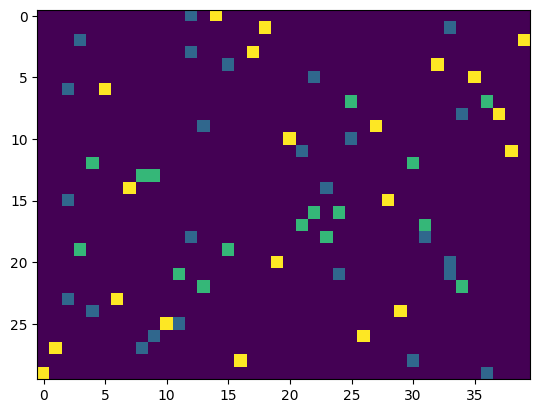

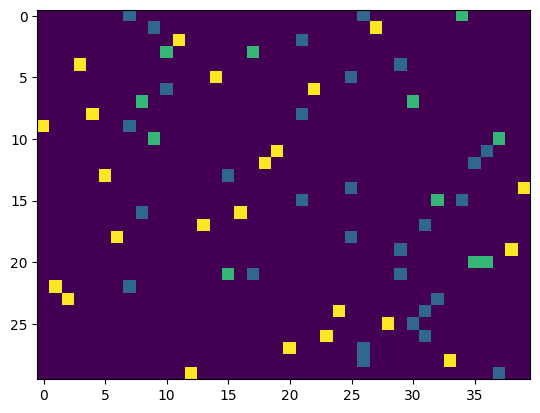

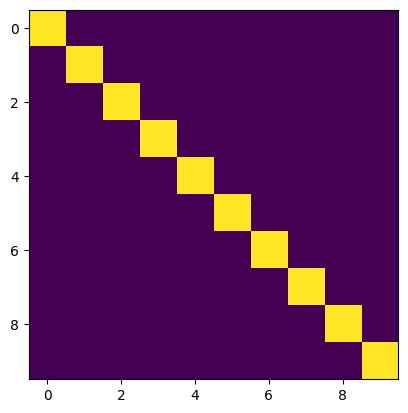

In [111]:
aligned, T_vars = get_wassersteinized_layers_modularized(args, [models['trained'][0], models['trained'][1]])

for T_var in T_vars:
    fig, ax = plt.subplots()
    im = ax.imshow(T_var.cpu().numpy())

In [114]:
model = Net(40)
validate(models['trained'][0].to(device), criterion, [], [])
validate(models['untrained'][1].to(device), criterion, [], [])
validate(model.to(device), criterion, [], [])
with torch.no_grad():
    model.fc1.weight = nn.Parameter(aligned[0])
    model.fc2.weight = nn.Parameter(aligned[1])
    model.fc3.weight = nn.Parameter(aligned[2])
validate(model.to(device), criterion, [], [])


Validation set: Average loss: 0.1756, Accuracy: 9445/10000 (94%)


Validation set: Average loss: 2.3049, Accuracy: 968/10000 (10%)


Validation set: Average loss: 2.3041, Accuracy: 773/10000 (8%)


Validation set: Average loss: 2.4477, Accuracy: 1905/10000 (19%)

